In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2023-07-18 06:50:28.141547: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 06:50:28.144877: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 06:50:28.186888: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 06:50:28.187892: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 06:50:29.493201: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# len(weights_ann_1[0].ravel())

In [4]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [5]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [6]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [7]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [8]:
samp_ann =  ann(hidden = 8, input_shape = 64, output_shape = 1)

In [9]:
weights_ann_1 = samp_ann.get_weights()

In [10]:
h1  = samp_ann.layers[1].output.shape[-1]

In [11]:
h1

8

In [12]:
samp_ann.count_params()

529

In [13]:
hidden_neurons = h1

In [14]:
samp_ann_params = samp_ann.count_params()

In [15]:
def get_initial_X_t(data1, data2, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens)
    
#     initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out1, data2_stack1 = get_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens)
    
#     initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out2, data2_stack2 = get_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(2, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = generate_initial_ensembles(4, var_L, size_ens)
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    # initial_ensembles_for_D2 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
#     initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
#     initial_ensembles_for_D3_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_D[:,0,:]

In [16]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [17]:
from scipy.stats import beta

In [18]:
fudging_beta = beta(1,9)

In [19]:
def forward_operation(data1, data2, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2 )]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, 0].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2].reshape(-1,1) 
    
#     model_4 = softmax_weights[:, 3].reshape(-1,1)
    
    sum_weights = model_1 + model_2
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2,
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2
    
    # weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles,final_output, model_1, model_2

In [20]:
def forward_operation_test(data1, data2, combined_ensembles , size_ens):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :1].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1:2].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2:3].reshape(-1,1)
    
#     model_4 = softmax_weights[:, 3:4].reshape(-1,1)
    
    sum_weights = model_1 + model_2 
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 
    
    return X_t, initial_ensembles, final_output, model_1, model_2

In [21]:
total_weights = 2*(samp_ann.count_params() + 1 + 1)

In [22]:
reduction = 10

In [23]:
size_ens = total_weights//reduction
# total_weights//reduction

In [24]:
size_ens

106

In [25]:
G_t = [[1, 1]]
G_t = np.array(G_t).T

In [26]:
G_t.shape

(2, 1)

In [27]:
def get_predictions(data1, data2, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, w1, w2 = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    return weighted_alogp, w1, w2

In [28]:
def get_predictions_test(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, w1, w2 = forward_operation_test(data1, data2, initial_ensembles, size_ens = size_ens)
    return weighted_alogp, w1, w2

In [29]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1  + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t, _,_, _, _ = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [30]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [31]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [32]:
def get_updated_ensemble(data1, data2, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, 
                        fudging_var = None):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [33]:
target_dim = 1

In [34]:
lambda_D = 1

In [35]:
from joblib import Parallel, delayed

In [36]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -4:-3]
    cov_part = cov_part.mean(0)
    variances1 = tf.math.softplus(cov_part).numpy()
    n = shape
    return variances1, np.identity(n)*variances1

In [37]:
# idx = 1

In [38]:
with open("..//Data//gcn_cdr_train_pca_higher.pickle", "rb") as f: 
    catch_train = pickle.load(f)

In [39]:
with open("..//Data//gcn_cdr_test_pca_higher.pickle", "rb") as f: 
    catch_test = pickle.load(f)

In [40]:
import random

In [41]:
def prepare_data_train(catch_train, idxes): 
    # idxes = random.sample(range(0, catch_train[0].shape[0]), k = size)
    # idxes = list(idxes)
    data1, data2 = catch_train[0][idxes,:], catch_train[1][idxes,:]
    
    y_train = catch_train[-1][idxes].reshape(-1,1)
    
    return data1, data2, y_train 

In [42]:
def prepare_data_test( catch_test, size): 
    idxes = random.sample(range(0, catch_test[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2 = catch_test[0][idxes,:], catch_test[1][idxes,:]
    y_train = catch_test[-1][idxes].reshape(-1,1)
    return data1, data2, y_train

In [43]:
# data1_train, data2_train, data3_train, data4_train, y_train =  prepare_data_train(catch_train, size = 5000)

In [44]:
data1_test, data2_test, y_test =  prepare_data_test(catch_test, size = catch_test[0].shape[0])

In [45]:
from scipy.stats import pearsonr

In [46]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [47]:
batch_size = 2500

In [48]:
import random

In [49]:
from tqdm import tqdm_notebook

In [50]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 0.01, inflation_factor = 1.6, fudging_beta = beta(1,19), 
               fudging_var = 1e-3, print_true = True):
    
    # smiles_feats_train, rdkit_feats_train, smiles_feats_valid, rdkit_feats_valid, y_train, y_train_actual, y_valid, y_valid_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)
    # w1_catch = []
    # w2_catch = []

    train_rmse = []
    test_rmse = []
    # print("done initializing")
    
    train_idxes = random.sample(range(0, catch_train[0].shape[0]), k = catch_train[0].shape[0])
    
    train_chunks = list(chunks(train_idxes, batch_size))
    
    best_rmse_train = 10000
    
    data1_train, data2_train, y_train = prepare_data_train(catch_train, train_chunks[0])
    
    _, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train,
                                                                                                 size_ens = size_ens, var_weights = var_weights,
                                                                                                var_weight_weights = var_weight_weights,
                                                                                                             var_D = var_D)
    
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))
    patience = 0
    
    for i in range(0,300):
        
        train_chunks = random.sample(train_chunks, len(train_chunks))
        
        if print_true == True:
            print("epoch number is " +str(i))
        
        for chunk in (train_chunks):
        
            data1_train, data2_train, y_train = prepare_data_train(catch_train, chunk)
            
            
            
            initial_ensembles = get_updated_ensemble(data1_train, data2_train, initial_ensembles, y_train, size_ens = size_ens,
                                                 inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        
            G_u_train, w1, w2 = get_predictions(data1_train, data2_train, initial_ensembles, fudging_beta)
    
            li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)    
            ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)  
    
            width_train = ui_train - li_train
            avg_width_train = width_train.mean(0)[0]
    
            ind_train = (y_train >= li_train) & (y_train <= ui_train)
            coverage_train= ind_train.mean(0)[0]
    
            averaged_targets_train = G_u_train.mean(0).reshape(-1,1)
            rmse_train = np.sqrt(((y_train -averaged_targets_train)**2).mean(0))[0]
        
            pearsonr_train = pearsonr(averaged_targets_train.reshape(averaged_targets_train.shape[0],), 
                                 y_train.reshape(y_train.shape[0],))
        
            r_train = pearsonr_train.statistic
    
            G_u_test, _, _ = get_predictions_test(data1_test, data2_test, initial_ensembles)
    

    
            li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)     
            ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)   
    
            width_test = ui_test - li_test
            avg_width_test = width_test.mean(0)[0]
    
            ind_test = (y_test >= li_test) & (y_test <= ui_test)
            coverage_test= ind_test.mean(0)[0]
    
            averaged_targets_test = G_u_test.mean(0).reshape(-1,1)
            rmse_test = np.sqrt(((y_test -averaged_targets_test)**2).mean(0))[0]  
        
            pearsonr_test = pearsonr(averaged_targets_test.reshape(averaged_targets_test.shape[0],), 
                                 y_test.reshape(y_test.shape[0],))
        
            r_test = pearsonr_test.statistic
            
            train_rmse.append(rmse_train)
            
            test_rmse.append(rmse_test)
            
            if print_true == True: 
                print("Training Coverage, Widths, RMSE, and Pearson R")
                print(coverage_train, avg_width_train, rmse_train, r_train)
                print("Testing Coverage, Widths, RMSE, and Pearson R")
                print(coverage_test, avg_width_test, rmse_test, r_test)
                
            # w1_catch.append([w1.mean(), w1.std()])
            # w2_catch.append([w2.mean(), w2.std()])
                # print(w1.mean(), w1.std())

            if (rmse_train < best_rmse_train): 
                best_pearsonr_train = r_train
            # print("went here")
                best_train_width_mean = avg_width_train.mean()
                best_train_width = avg_width_train
                # best_smiles_weight = w1.mean()
                best_coverage_train = coverage_train
                best_rmse_train = rmse_train
                best_pearson_r = r_test
                best_test_width = avg_width_test

                best_coverage_test = coverage_test    
                best_rmse_test = rmse_test
                patience = 0
                best_ensembles = initial_ensembles
                best_w1_weight = w1.mean()
                best_w2_weight = w2.mean()
            
            else:
                patience = patience + 1
            
            if print_true == True:
                print("Patience is")
                print(patience)
                print('\n')
        
            if patience > threshold:
            
                # print()
                # print(best_train_width.tolist(), best_coverage_train.tolist(), best_rmse_train.tolist(), best_test_width.tolist(), best_coverage_test.tolist(), best_rmse_test.tolist(), best_smiles_weight, flush = True)
                # print("done for fold" + str(idx), flush = True)
                # print("train_coverage" + str(best_coverage_train), flush = True)
                print("test_coverage" + str(best_coverage_test), flush = True)
                # print("train_width" + str(best_train_width), flush = True)
                print("test_width" + str(best_test_width), flush = True)
                # print("smiles_weight" + str(best_smiles_weight), flush = True)
                # print("rmse_train" + str(best_rmse_train), flush = True)
                print("rmse_test" + str(best_rmse_test), flush = True)
                weights = [best_w1_weight, best_w2_weight]
                print("weights", flush = True)
                print(weights, flush = True)
                print('\n', flush = True)
                # print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
            
                return [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, best_w1_weight, best_w2_weight]


In [51]:
threshold = 10

In [56]:
%%time
best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r,  \
best_ensembles, train_rmse, test_rmse, best_w1_weight, best_w2_weight = get_results(0, var_weights = 0.08, var_weight_weights = 1, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 3*1e-3, print_true = True)

epoch number is 0
Training Coverage, Widths, RMSE, and Pearson R
0.4192 16.42509539912892 12.405440218890433 0.38954836836133955
Testing Coverage, Widths, RMSE, and Pearson R
0.4089281589281589 16.379457387842013 12.603621239581285 0.36289777971544157
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.5012 5.83736360383367 4.470787252279629 0.3380644507882842
Testing Coverage, Widths, RMSE, and Pearson R
0.5165165165165165 5.8383949006193285 4.343524870975 0.3602444786780487
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.6848 4.519364297391427 2.253594384354243 0.6408782064770243
Testing Coverage, Widths, RMSE, and Pearson R
0.682952182952183 4.547414506436371 2.2463009516812678 0.648299037420048
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.8188 5.048637277909752 1.811519622803143 0.7592723322378312
Testing Coverage, Widths, RMSE, and Pearson R
0.8086163086163086 5.079059153946734 1.864023026445225 0.7527492523044431
Patience is
0


T

In [57]:
preds_test, _, _ = get_predictions_test(data1_test, data2_test, best_ensembles)

In [58]:
averaged_preds_test = preds_test.mean(0).reshape(-1,1)

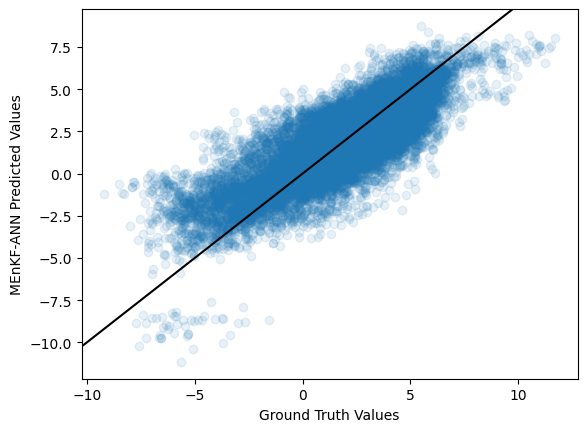

In [59]:
plt.scatter(y_test, averaged_preds_test, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.xlabel("Ground Truth Values")
plt.ylabel("MEnKF-ANN Predicted Values")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
plt.show()

In [60]:
items = [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r,best_w1_weight, best_w2_weight]

In [61]:
items_df = pd.DataFrame(items).T

In [62]:
items_df.columns = ['best_train_width', 'best_coverage_train', 'best_rmse_train', 'best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r', 
                   'best_w1_weight', 'best_w2_weight']

In [63]:
items_df = items_df.T

In [ ]:
# items_df.columns = ["Value"]

In [64]:
items_df

,0
best_train_width,6.012718
best_coverage_train,0.909200
best_rmse_train,1.584488
best_test_width,5.971422
best_coverage_test,0.899688
best_rmse_test,1.654635
best_pearson_r,0.811469
best_w1_weight,0.219784
best_w2_weight,0.780216


In [65]:
preds_test.shape

(106, 17316)

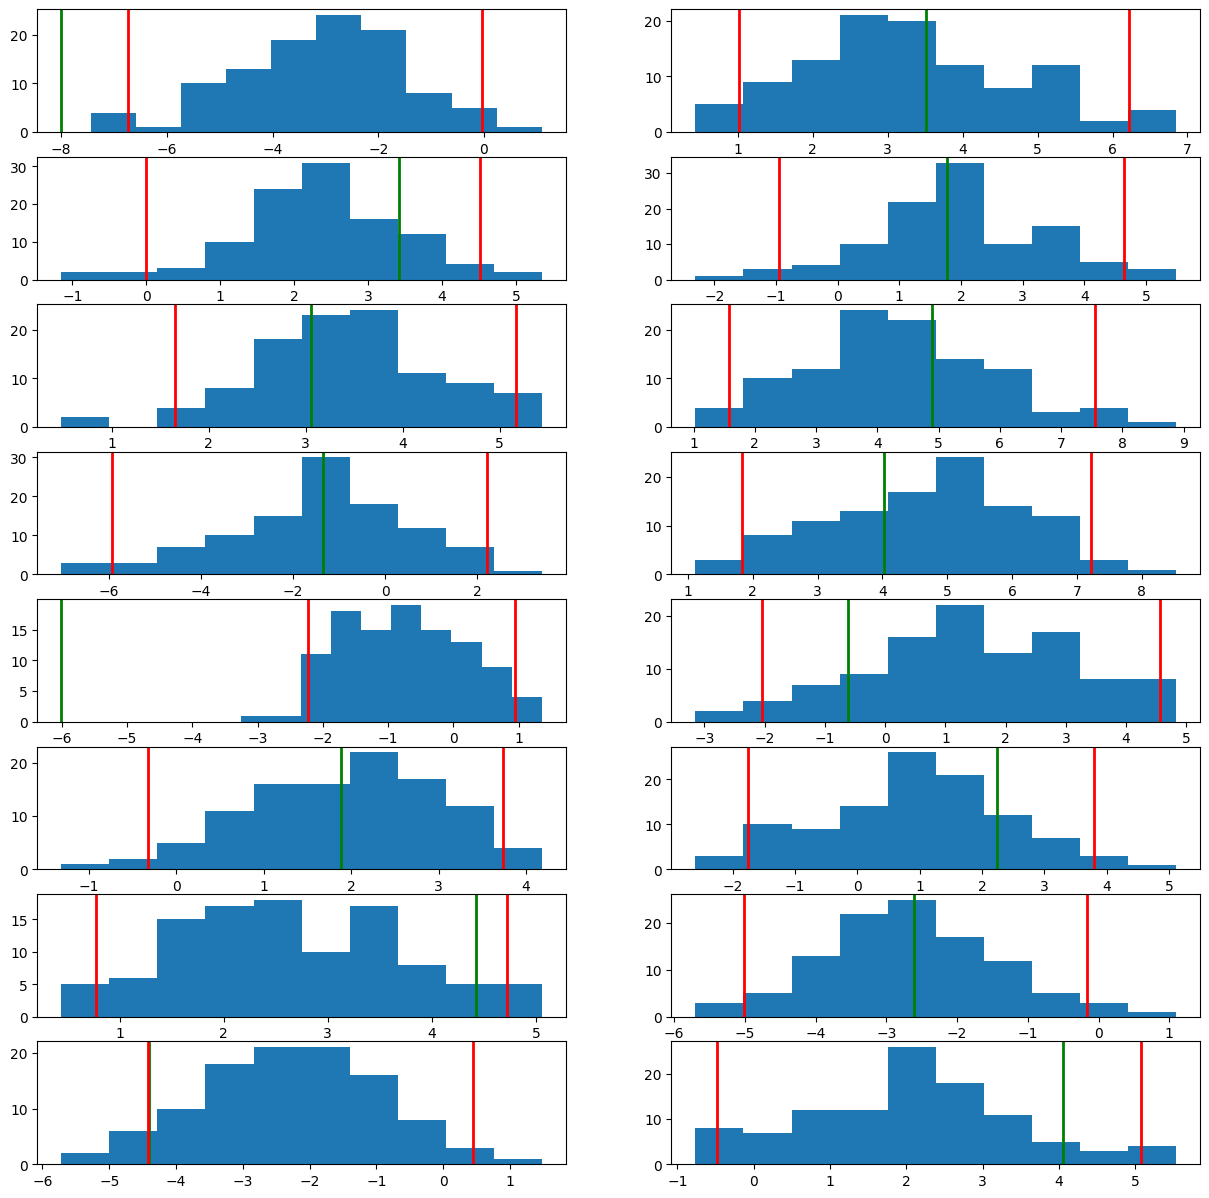

In [66]:
random_idx = random.sample(range(y_test.shape[0]), k = 16)
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
axs = axs.ravel()
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_test[i,:]
    preds = preds_test[:, i]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0]
    uis = percts[1]
    
    
    axs[idx].hist(preds)
    axs[idx].axvline(truth, color='green', linewidth=2)
    axs[idx].axvline(lis, color='red', linewidth=2)
    axs[idx].axvline(uis, color='red', linewidth=2)

# plt.title
fig.savefig('gcn_cdr_pred_intervals.png', bbox_inches='tight')
plt.show()


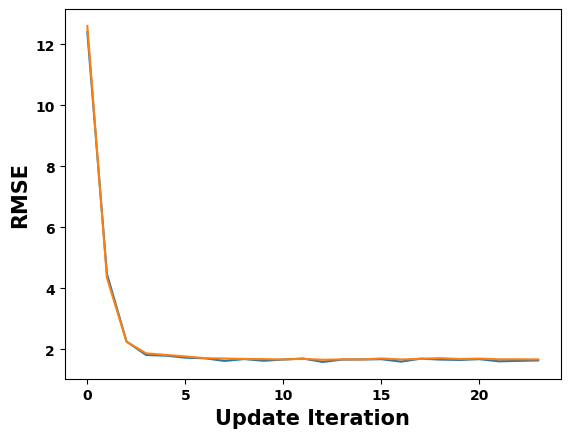

In [67]:
plt.plot(train_rmse)
plt.plot(test_rmse)
plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("RMSE", fontsize = 15, fontweight = "bold")
plt.xticks( fontsize = 10, fontweight = "bold")
plt.yticks( fontsize = 10, fontweight = "bold")
plt.show()

In [ ]:
# plt.hist(y_train)
# plt.show()

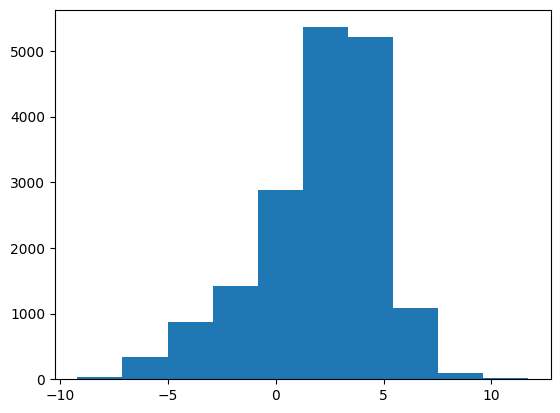

In [68]:
plt.hist(y_test)
plt.show()

In [69]:
catch = Parallel(n_jobs = 14, verbose = 8, backend = "loky")(delayed(get_results)(idx, var_weights = 1, var_weight_weights = 1, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 3*1e-3, print_true = False) for idx in range(0,50))

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


test_coverage0.9975744975744976
test_width16.169933492300046
rmse_test1.6998985794813675
weights
[0.7209076237118037, 0.27909237628819633]


test_coverage0.76998151998152
test_width3.9794320583896083
rmse_test1.660857257915596
weights
[0.07747037007265388, 0.922529629927346]


test_coverage0.8385885885885885
test_width4.769374382634583
rmse_test1.6626637838673883
weights
[0.18607122049131972, 0.8139287795086803]


test_coverage0.9814622314622314
test_width10.613802042041682
rmse_test1.6948305607750835
weights
[0.5045131600883357, 0.4954868399116643]


test_coverage0.8093093093093093
test_width4.384585152393076
rmse_test1.653108661803101
weights
[0.09740300385638928, 0.9025969961436108]


test_coverage0.9804227304227304
test_width11.023811452363077
rmse_test1.6748121980453483
weights
[0.4138151785384375, 0.5861848214615625]


test_coverage0.9118156618156619
test_width6.476367641008696
rmse_test1.6726491117272897
weights
[0.20525533267802298, 0.7947446673219772]


test_coverage0.85250635

[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed: 17.5min


test_coverage0.9984407484407485
test_width20.885593425601666
rmse_test1.7110966984243376
weights
[0.8138173565694184, 0.1861826434305817]


test_coverage0.8332755832755833
test_width4.882685686787617
rmse_test1.6909045861855136
weights
[0.19645861153199679, 0.8035413884680034]


test_coverage0.9998844998844999
test_width28.459241370588867
rmse_test1.7553464548417914
weights
[0.9469165211987023, 0.05308347880129762]


test_coverage0.8150843150843151
test_width4.536652455176534
rmse_test1.666055425488462
weights
[0.11128699520929251, 0.8887130047907077]


test_coverage0.9453684453684453
test_width7.446126661704138
rmse_test1.676556250437711
weights
[0.2726020485693751, 0.727397951430625]


test_coverage0.8536036036036037
test_width4.979818575394206
rmse_test1.6570887732867925
weights
[0.14305850019188693, 0.8569414998081131]


test_coverage0.9974589974589975
test_width13.883185343956566
rmse_test1.6881814921493092
weights
[0.34930727948680723, 0.6506927205131928]


test_coverage0.8418803

[Parallel(n_jobs=14)]: Done  30 out of  50 | elapsed: 29.0min remaining: 19.3min


test_coverage0.765015015015015
test_width3.952203279163933
rmse_test1.6737983230113074
weights
[0.07925036692862532, 0.9207496330713746]


test_coverage0.98995148995149
test_width12.394666437186203
rmse_test1.7366745495109388
weights
[0.33318784509460736, 0.6668121549053925]


test_coverage0.9712982212982213
test_width9.202580121663857
rmse_test1.6685420362309764
weights
[0.3547324196944577, 0.6452675803055422]


test_coverage0.8965118965118966
test_width5.773309340311882
rmse_test1.652434955604037
weights
[0.11302625405032828, 0.8869737459496717]


test_coverage0.9352044352044352
test_width6.984282679894014
rmse_test1.672520014773177
weights
[0.20971241162585633, 0.7902875883741437]


test_coverage0.8099445599445599
test_width4.494011159624418
rmse_test1.6630270826246543
weights
[0.12669109396900063, 0.8733089060309994]


test_coverage0.9275236775236775
test_width6.481269927499513
rmse_test1.6493954729527285
weights
[0.24318703932107927, 0.7568129606789207]




[Parallel(n_jobs=14)]: Done  37 out of  50 | elapsed: 36.1min remaining: 12.7min


test_coverage0.709055209055209
test_width3.498816383881724
rmse_test1.6624767767090607
weights
[0.06944002593740399, 0.930559974062596]


test_coverage0.8367405867405867
test_width4.79424297597629
rmse_test1.6639127653524273
weights
[0.13707148092593496, 0.8629285190740651]


test_coverage0.78003003003003
test_width4.031013572504212
rmse_test1.6563167689096483
weights
[0.10091224768756407, 0.8990877523124359]


test_coverage0.9989027489027489
test_width17.542192301218737
rmse_test1.6817601894661456
weights
[0.6692172049698673, 0.3307827950301328]


test_coverage0.6879764379764379
test_width3.307925391615787
rmse_test1.6581880731818364
weights
[0.05523850646055738, 0.9447614935394427]


test_coverage0.9702587202587203
test_width9.032969283321393
rmse_test1.6750255847319895
weights
[0.3699681928407415, 0.6300318071592587]


test_coverage0.8548163548163548
test_width5.039527956215942
rmse_test1.6551441854042734
weights
[0.0894567059820704, 0.9105432940179297]




[Parallel(n_jobs=14)]: Done  44 out of  50 | elapsed: 39.0min remaining:  5.3min


test_coverage0.7128667128667129
test_width3.4573113827126
rmse_test1.659029082855088
weights
[0.11405991123929288, 0.8859400887607071]


test_coverage0.9325479325479326
test_width7.3715594007138705
rmse_test1.6528186854323874
weights
[0.3502412009384916, 0.6497587990615084]


test_coverage0.9861977361977362
test_width10.592713332302692
rmse_test1.6882295173985276
weights
[0.3106740436796551, 0.6893259563203449]


test_coverage0.8581081081081081
test_width5.1415284253784845
rmse_test1.654134510207556
weights
[0.1752962954565792, 0.8247037045434208]


test_coverage1.0
test_width31.61378815100685
rmse_test1.784803639391407
weights
[0.961992001307004, 0.03800799869299612]


test_coverage1.0
test_width27.663666975547464
rmse_test1.710280989380875
weights
[0.8319177796524291, 0.16808222034757103]




[Parallel(n_jobs=14)]: Done  50 out of  50 | elapsed: 43.8min finished


In [70]:
with open("..//Data//DeepCDR_run_config2.pickle", "wb") as f: 
    pickle.dump(catch, f)

In [71]:
with open("..//Data//DeepCDR_run_config2.pickle", "rb") as f: 
    catch = pickle.load(f)

In [72]:
all_metrics = []
all_weights = []
for i in range(0,50):
    item = catch[i]
    metrics = item[:7]
    weights = item[-2:]
    all_metrics.append(metrics)
    all_weights.append(weights)
    

In [73]:
all_metrics_df = pd.DataFrame(all_metrics)

In [74]:
all_weights_df = pd.DataFrame(all_weights)

In [75]:
all_df = pd.concat([all_metrics_df, all_weights_df], axis = 1)

In [76]:
all_df.columns = ['train_width', 'coverage_train', 'rmse_train', 'test_width', 'coverage_test', 'rmse_test', 'pearson_r', 
                    "DeepCDR_Drugs", "DeepCDR_Omics"]

In [77]:
all_df.mean()

train_width       9.888264
coverage_train    0.904857
rmse_train        1.606555
test_width        9.904188
coverage_test     0.894568
rmse_test         1.684192
pearson_r         0.805091
DeepCDR_Drugs     0.328029
DeepCDR_Omics     0.671971
dtype: float64

In [78]:
all_df.std()

train_width       7.710270
coverage_train    0.092687
rmse_train        0.052801
test_width        7.718959
coverage_test     0.100048
rmse_test         0.038581
pearson_r         0.009050
DeepCDR_Drugs     0.265252
DeepCDR_Omics     0.265252
dtype: float64